In [1]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *

#path dove stanno i dati del fit
now_path        =   '../BRILLOUIN/TDP43/NO_ARS_12_02/analysis/'
n_rows          =   101
n_cols          =   83

matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)
print(len(rows), len(cols))

Ho inizializzato una matrice 101x83, per un totale di 8383 spettri
101 83


In [2]:
#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

"""
with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)

matrix[0][0].Recover_VIPA(x_VIPA, y_VIPA)
"""
count = 0
for ii in range(len(rows)):
    for jj in range(len(cols)):
        #print(lines[count],lines[count+1] )
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [3]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')



Ok ho recuperato le informazioni del Fit Markoviano


In [4]:
omega_too_high = Whose_Param_Too_High('Omega', 8.2, 'markov', matrix, boni)
print(len(omega_too_high))

(5, 46) ha Omega= 8.91
(35, 35) ha Omega= 8.92
(36, 16) ha Omega= 8.91
(44, 53) ha Omega= 8.89
(44, 74) ha Omega= 8.92
(44, 76) ha Omega= 8.93
(56, 13) ha Omega= 8.92
(56, 31) ha Omega= 8.93
(58, 28) ha Omega= 8.93
(58, 75) ha Omega= 8.36
(60, 15) ha Omega= 8.93
(61, 44) ha Omega= 8.91
(65, 47) ha Omega= 8.93
(65, 72) ha Omega= 8.93
(66, 46) ha Omega= 8.91
(74, 74) ha Omega= 8.92
(75, 13) ha Omega= 8.91
(76, 42) ha Omega= 8.93
(78, 42) ha Omega= 8.93
(82, 59) ha Omega= 8.73
(84, 19) ha Omega= 8.68
(96, 51) ha Omega= 8.37
22


In [4]:


omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'seismic', 7.3,8., fig = 'Delta_omega_markov_map', path=now_path)


Completata Parameter_Map per Omega
Ho trovato 67 elementi saturati


In [7]:
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.7, fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)

Completata Parameter_Map per Omega
Ho trovato 67 elementi saturati


In [8]:
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'seismic', 0.1,0.25, fig = 'Gamma_markov_map', path=now_path)

Completata Parameter_Map per Gamma
Ho trovato 67 elementi saturati


In [24]:
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.05, fig = 'Delta_gamma_markov_map', path=now_path, Deltas = True)

Completata Parameter_Map per Gamma
Ho trovato 133 elementi saturati


(78, 1)


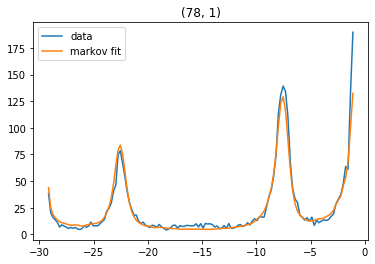

[ 1.66015204e-01  7.50162578e+00  1.54341624e-01  2.47074310e-01
  1.45634814e+00  2.44589877e+03 -1.07409250e+01  1.74809816e+01
 -5.55682584e-02  4.13083477e-01]


In [16]:
Plot_Elements_Spectrum(matrix, [(78,1)], fit = 'markov')
print(matrix[78][1].Markov_Fit_Params.values[0])

In [13]:
(50,84) in excluded

True

In [8]:
#funz da aggiungere lib_exp
def Whose_Param_Too_High(param, treshold, fit,  matrix, fitted):


    if fit == 'markov':
        attr = 'Markov_Fit_Params'
    elif fit == 'tot':
        attr = 'Tot_Fit_Params'
    else:raise ValueError("Select a type of fit: 'markov' or 'tot' ")
    too_high    =   ()

    for (ii,jj) in (fitted):
        if getattr(matrix[ii][jj],attr)[param]['Values'] > treshold:
            too_high    =   too_high    +   ((ii,jj),)
            print(str((ii,jj))+' ha '+param+'= %3.2f'%(getattr(matrix[ii][jj],attr)[param]['Values']))

    return too_high

def Whose_Param_Too_Low(param, treshold, fit, matrix, fitted):

    if fit == 'markov':
        attr = 'Markov_Fit_Params'
    elif fit == 'tot':
        attr = 'Tot_Fit_Params'
    else:raise ValueError("Select a type of fit: 'markov' or 'tot' ")

    too_low    =   ()

    for (ii,jj) in (fitted):
        if getattr(matrix[ii][jj],attr)[param]['Values'] <= treshold:
            too_low    =   too_low    +   ((ii,jj),)
            print(str((ii,jj))+' ha '+param+'= %3.2f'%(getattr(matrix[ii][jj],attr)[param]['Values'][param]['Values']))

    return too_low
def Plot_Elements_Spectrum(matrix, elements_iterable, fit = False, pix = False, peaks = False):

    if pix:

        attribute = 'x'
        
    else:
        attribute = 'x_freq'

    for (ii,jj) in elements_iterable:
        
        print(str((ii,jj)))
        plt.figure()
        plt.plot(getattr(matrix[ii][jj], attribute), matrix[ii][jj].y, label = 'data')

        if fit:
                
            if fit == 'markov':
                plt.plot(getattr(matrix[ii][jj], attribute), matrix[ii][jj].y_markov_fit, label = 'markov fit')

            elif fit == 'tot':
                plt.plot(getattr(matrix[ii][jj], attribute), matrix[ii][jj].y_fit, label = 'tot fit')

        if peaks:
            #anche se non funziona con x_freq i picchi, o forse sì?
            plt.plot(getattr(matrix[ii][jj], attribute)[matrix[ii][jj].peaks[0]], matrix[ii][jj].y[matrix[ii][jj].peaks[0]], '+', label = 'peaks')
        
        plt.title(str((ii,jj)))
        plt.legend()
        plt.show()

In [ ]:
################ TOTALE

#with open(now_path+'y_tot_fit.txt', 'r') as fin:
#    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

#for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    #matrix[ii][jj].Recover_y_fit(y_fit)
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

In [4]:
matrix[0][0].y_markov_fit

array([ 6.47210492,  6.46389804,  6.45566781,  6.44764676,  6.4407845 ,
        6.43598151,  6.43369209,  6.43402582,  6.43675031,  6.44097345,
        6.4453177 ,  6.44905109,  6.45290483,  6.45812844,  6.46463217,
        6.4704768 ,  6.47328379,  6.471939  ,  6.46707728,  6.46033542,
        6.45322433,  6.44646041,  6.44015935,  6.43451764,  6.43006163,
        6.42711011,  6.42525623,  6.42372209,  6.42216741,  6.42085111,
        6.41998269,  6.41920517,  6.41786768,  6.41569016,  6.41309902,
        6.41101928,  6.41035673,  6.41152897,  6.41433683,  6.41814692,
        6.42210584,  6.42533496,  6.42727487,  6.42801521,  6.42816003,
        6.4282673 ,  6.42851389,  6.42889579,  6.42945062,  6.43006429,
        6.43026923,  6.4296305 ,  6.42852284,  6.4284306 ,  6.43119986,
        6.43772003,  6.4473057 ,  6.45853386,  6.47071092,  6.48432919,
        6.50002127,  6.51726672,  6.53426496,  6.54898105,  6.56032441,
        6.56865403,  6.57541101,  6.58208255,  6.58931533,  6.59